In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt 
from IPython import display
import glob
import math

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set(
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

np.random.seed(123123123)

In [2]:
#this function will help us analyze and compare model performance later
def plot_acc_loss(history):
    plt.figure(figsize = (20, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'])

## Define dataset folder path below (ensure '/' is the last character)

In [3]:
DATA_FOLDER = 'tumor_dataset/'

## Data importing
We will define constants and functions which will aid in importing the data into our python environment.

In [4]:
#Set up vars which point to image type, and the folders of LGG and HGG tumor data
image_types = ['MR_Flair', 'MR_T1', 'MR_T1c', 'MR_T2', 'OT']
directory_LGG = DATA_FOLDER + 'train/LGG/*/*'
directory_HGG = DATA_FOLDER + 'train/HGG/*/*'

#Define functions for 1) get data filepaths 2) get slices from data 3) normalize the data 4) average all slices
#1)
def get_mha_filepaths(image_type, directory_path):
    '''Takes image_type, directory_path as strings. Returns a list of absolute image paths'''
    return [_ for _ in glob.glob(directory_path) if _.split('/')[-1].split('.')[-3] == image_type]

#2)
def get_slice_from_filepath(mha_filepath, slice_index):
    volume = sitk.ReadImage(mha_filepath)
    volume_arr = sitk.GetArrayFromImage(volume)
    img_arr = volume_arr[slice_index]
    return normalize(img_arr)

#3)
def normalize(arr):
    return arr/np.linalg.norm(arr)

#4)
def get_average_slice(mha_filepath, num_slices):
    #takes slice 155/2 for num_slices = 1
    
    slices = []
    for i in range(1,num_slices+1):
        slices.append(get_slice_from_filepath(mha_filepath, int(i*155/(num_slices+1))))

    return normalize(sum(slices))

## Importing data
Now we will import the data. Time to run increases significantly as the number of slices for get_average_slice increases. Takes middle slice when number of slices is 1

In [5]:
#obtain file paths for lgg and hgg data
flair_paths_LGG = get_mha_filepaths(image_types[0], directory_LGG)
flair_paths_HGG = get_mha_filepaths(image_types[0], directory_HGG)

#Store slice data
flair_mri_LGG = np.array([get_average_slice(filepath,1) for filepath in flair_paths_LGG])
flair_mri_HGG = np.array([get_average_slice(filepath,1) for filepath in flair_paths_HGG])


#create labels for data
labels_LGG = np.array([0 for _ in range(len(flair_mri_LGG))])
labels_HGG = np.array([1 for _ in range(len(flair_mri_HGG))])

print(len(flair_mri_LGG))
print(len(flair_mri_HGG))

54
220


## Dealing with skewed data
Will use class weights as described in https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [6]:
LGG_weight = (1/len(flair_mri_LGG))*(len(flair_mri_LGG)+len(flair_mri_HGG))/2
HGG_weight = (1/len(flair_mri_HGG))*(len(flair_mri_LGG)+len(flair_mri_HGG))/2

class_weight = {0: LGG_weight, 1: HGG_weight}

print('Weight for class 0: {:.2f}'.format(LGG_weight))
print('Weight for class 1: {:.2f}'.format(HGG_weight))


Weight for class 0: 2.54
Weight for class 1: 0.62


Now we split data into test and trains

In [7]:
data = np.concatenate((flair_mri_LGG, flair_mri_HGG), axis=0)
labels = np.concatenate((labels_LGG, labels_HGG), axis=0)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = .2, shuffle=True)

# Feed Forward Neural Network

In [8]:
ffnn = keras.models.Sequential([keras.layers.Flatten(input_shape = [240, 240]),
    keras.layers.Dense(300, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(2, activation = 'softmax' )])

opt = keras.optimizers.SGD(learning_rate=0.005)

ffnn.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = opt, metrics = ['accuracy'])

## Train the model

In [9]:
ffnn_history = ffnn.fit(x_train, y_train, epochs = 3000, validation_split = 0.3, class_weight = class_weight)

Epoch 1/3000
5/5 [==============================] - 1s 186ms/step - loss: 0.7137 - accuracy: 0.4194 - val_loss: 0.6937 - val_accuracy: 0.2121
Epoch 2/3000
5/5 [==============================] - 0s 37ms/step - loss: 0.6630 - accuracy: 0.4451 - val_loss: 0.6947 - val_accuracy: 0.1061
Epoch 3/3000
5/5 [==============================] - 0s 37ms/step - loss: 0.7134 - accuracy: 0.2125 - val_loss: 0.6949 - val_accuracy: 0.1061
Epoch 4/3000
5/5 [==============================] - 0s 39ms/step - loss: 0.6835 - accuracy: 0.1899 - val_loss: 0.6953 - val_accuracy: 0.1061
Epoch 5/3000
5/5 [==============================] - 0s 39ms/step - loss: 0.7408 - accuracy: 0.2333 - val_loss: 0.6950 - val_accuracy: 0.1061
Epoch 6/3000
5/5 [==============================] - 0s 41ms/step - loss: 0.7045 - accuracy: 0.2060 - val_loss: 0.6956 - val_accura

## Test model

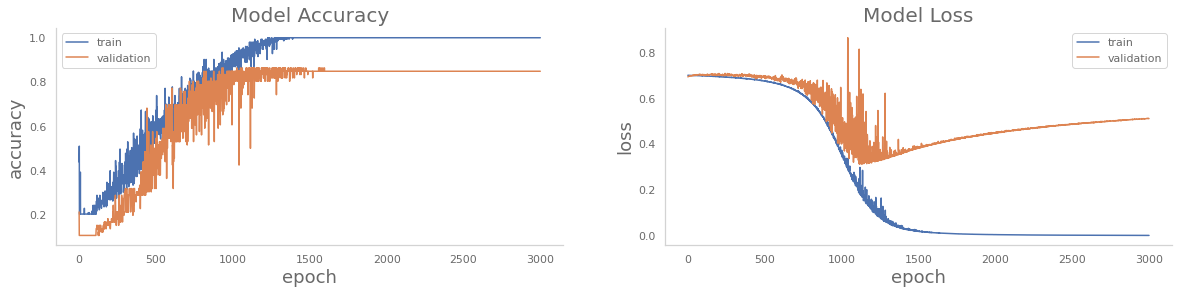

In [10]:
plot_acc_loss(ffnn_history)

In [11]:
ffnn_score = ffnn.evaluate(x_test, y_test, verbose=2)

2/2 - 0s - loss: 1.0220 - accuracy: 0.8000


In [12]:
#proportion of HGG in test data
print(sum(y_test)/len(y_test))

0.7090909090909091


# Feed Forward Neural Network with slice averaging
First we will create new data using slice averaging

In [13]:
#NUM OF SLICES
NUM_SLICES = 5

#Store average slice data
flair_mri_LGG_avg = np.array([get_average_slice(filepath,NUM_SLICES) for filepath in flair_paths_LGG])
flair_mri_HGG_avg = np.array([get_average_slice(filepath,NUM_SLICES) for filepath in flair_paths_HGG])

#generate test and train sets
data_avg = np.concatenate((flair_mri_LGG, flair_mri_HGG), axis=0)

x_train_avg, x_test_avg, y_train_avg, y_test_avg = train_test_split(data_avg, labels, test_size = .2, shuffle=True)

In [14]:
ffnn_avg = keras.models.Sequential([keras.layers.Flatten(input_shape = [240, 240]),
    keras.layers.Dense(300, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(2, activation = 'softmax' )])

opt = keras.optimizers.SGD(learning_rate=0.005)

ffnn_avg.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = opt, metrics = ['accuracy'])

In [15]:
ffnn_avg_history = ffnn_avg.fit(x_train_avg, y_train_avg, epochs = 3000, validation_split = 0.3, class_weight = class_weight)

Epoch 1/3000
5/5 [==============================] - 1s 115ms/step - loss: 0.7290 - accuracy: 0.2242 - val_loss: 0.6945 - val_accuracy: 0.1818
Epoch 2/3000
5/5 [==============================] - 0s 39ms/step - loss: 0.6716 - accuracy: 0.2095 - val_loss: 0.6951 - val_accuracy: 0.1818
Epoch 3/3000
5/5 [==============================] - 0s 37ms/step - loss: 0.6813 - accuracy: 0.1882 - val_loss: 0.6957 - val_accuracy: 0.1818
Epoch 4/3000
5/5 [==============================] - 0s 41ms/step - loss: 0.6979 - accuracy: 0.2008 - val_loss: 0.6958 - val_accuracy: 0.1818
Epoch 5/3000
5/5 [==============================] - 0s 41ms/step - loss: 0.7155 - accuracy: 0.2142 - val_loss: 0.6960 - val_accuracy: 0.1818
Epoch 6/3000
5/5 [==============================] - 0s 37ms/step - loss: 0.7120 - accuracy: 0.2116 - val_loss: 0.6961 - val_accura

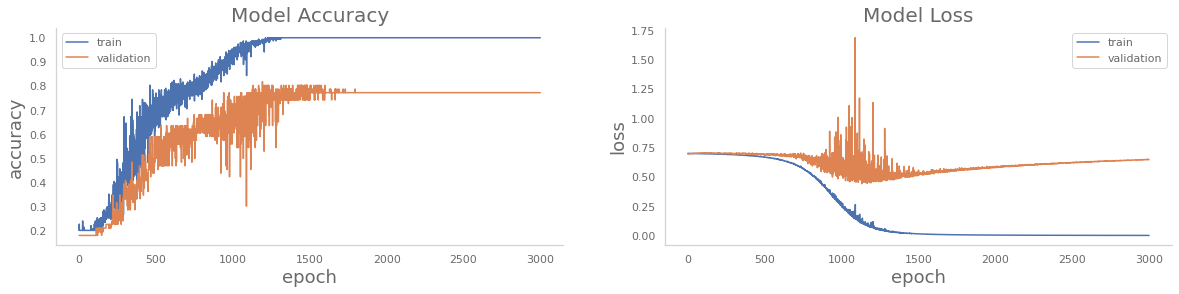

In [16]:
plot_acc_loss(ffnn_avg_history)

In [17]:
ffnn_avg_score = ffnn_avg.evaluate(x_test_avg, y_test_avg, verbose=2)

2/2 - 0s - loss: 0.6733 - accuracy: 0.8182


# KNN

First we need to create flattened versions of our images

In [18]:
x_train_knn = [x.flatten() for x in x_train]
x_train_avg_knn = [x.flatten() for x in x_train_avg]

x_test_knn = [x.flatten() for x in x_test]
x_test_avg_knn = [x.flatten() for x in x_train_avg]

np.shape(x_train_knn)

(219, 57600)

In [19]:
knn = KNeighborsClassifier(n_neighbors = 8, p = 2)
knn.fit(x_train_knn, y_train)
knn_prediction_labels = knn.predict(x_test_knn)
print("KNN accuracy:", accuracy_score(y_test, knn_prediction_labels))

KNN accuracy: 0.8


# Nothing is working, so let's try undersampling
Shrink size of HGG to match LGG

In [20]:
flair_mri_HGG_under = flair_mri_HGG[:54]
print(len(flair_mri_HGG_under))

54


In [21]:
data_under = np.concatenate((flair_mri_LGG, flair_mri_HGG_under), axis=0)
labels_under = np.concatenate((labels_LGG, labels_HGG[:54]), axis=0)

x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(data_under, labels_under, test_size = .3, shuffle=True)

In [22]:
ffnn_under = keras.models.Sequential([keras.layers.Flatten(input_shape = [240, 240]),
    keras.layers.Dense(300, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(2, activation = 'softmax' )])

opt = keras.optimizers.SGD(learning_rate=0.005)

ffnn_under.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = opt, metrics = ['accuracy'])

In [23]:
ffnn_under_history = ffnn_under.fit(x_train_under, y_train_under, epochs = 3000, validation_split = 0.3)

Epoch 1/3000
2/2 [==============================] - 1s 253ms/step - loss: 0.6931 - accuracy: 0.5441 - val_loss: 0.6930 - val_accuracy: 0.6087
Epoch 2/3000
2/2 [==============================] - 0s 84ms/step - loss: 0.6930 - accuracy: 0.5208 - val_loss: 0.6930 - val_accuracy: 0.5652
Epoch 3/3000
2/2 [==============================] - 0s 91ms/step - loss: 0.6930 - accuracy: 0.6546 - val_loss: 0.6929 - val_accuracy: 0.6087
Epoch 4/3000
2/2 [==============================] - 0s 86ms/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6927 - val_accuracy: 0.6087
Epoch 5/3000
2/2 [==============================] - 0s 253ms/step - loss: 0.6929 - accuracy: 0.5128 - val_loss: 0.6926 - val_accuracy: 0.6087
Epoch 6/3000
2/2 [==============================] - 0s 81ms/step - loss: 0.6929 - accuracy: 0.5024 - val_loss: 0.6924 - val_accura

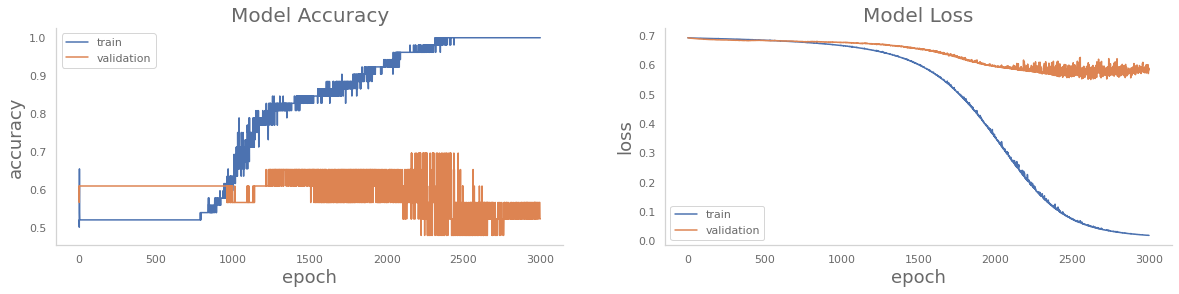

In [24]:
plot_acc_loss(ffnn_under_history)

In [25]:
ffnn_under_score = ffnn_under.evaluate(x_test_under, y_test_under, verbose=2)

2/2 - 0s - loss: 0.8697 - accuracy: 0.6061


# Attempting some sort of feature extraction

In [26]:
LGG_subset = np.array(flair_mri_LGG[:10], copy = True)
HGG_subset = np.array(flair_mri_HGG[:10], copy = True)
data_subset = np.array(list(LGG_subset) + list(HGG_subset))

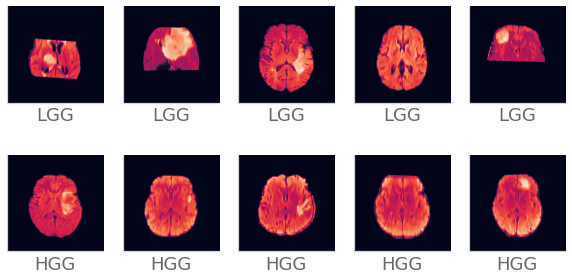

In [27]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_subset[i])
    plt.xlabel('LGG' if i < 5 else 'HGG')
plt.show()

In [28]:
def feature_extraction(scan):
    for r in range(len(scan)):
        for c in range(len(scan[r])):
            if scan[r][c] < .011:
                scan[r][c] = 0

In [29]:
for scan in data_subset:
    feature_extraction(scan)

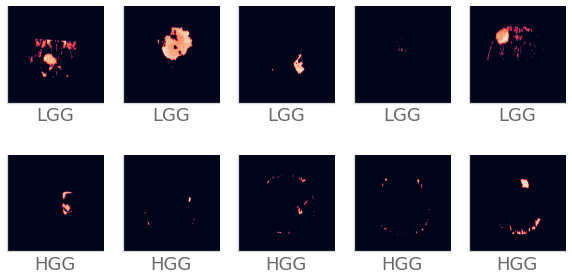

In [30]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_subset[i])
    plt.xlabel('LGG' if i < 5 else 'HGG')
plt.show()

In [31]:
for scan in x_train:
    feature_extraction(scan)

for scan in x_test:
    feature_extraction(scan)

In [32]:
ffnn_feature = keras.models.Sequential([keras.layers.Flatten(input_shape = [240, 240]),
    keras.layers.Dense(300, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(100, activation = 'relu' ),
    keras.layers.Dense(2, activation = 'softmax' )])

opt = keras.optimizers.SGD(learning_rate=0.005)

ffnn_feature.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = opt, metrics = ['accuracy'])

In [37]:
ffnn_feature_history = ffnn_feature.fit(x_train, y_train, epochs = 3000, validation_split = 0.3, class_weight = class_weight)

Epoch 1/3000
5/5 [==============================] - 1s 62ms/step - loss: 0.7004 - accuracy: 0.6144 - val_loss: 0.6924 - val_accuracy: 0.8485
Epoch 2/3000
5/5 [==============================] - 0s 43ms/step - loss: 0.7002 - accuracy: 0.7712 - val_loss: 0.6928 - val_accuracy: 0.6061
Epoch 3/3000
5/5 [==============================] - 0s 85ms/step - loss: 0.7001 - accuracy: 0.6144 - val_loss: 0.6928 - val_accuracy: 0.5758
Epoch 4/3000
5/5 [==============================] - 0s 47ms/step - loss: 0.7001 - accuracy: 0.6863 - val_loss: 0.6937 - val_accuracy: 0.3636
Epoch 5/3000
5/5 [==============================] - 0s 45ms/step - loss: 0.7000 - accuracy: 0.5490 - val_loss: 0.6947 - val_accuracy: 0.1667
Epoch 6/3000
5/5 [==============================] - 0s 43ms/step - loss: 0.6999 - accuracy: 0.2484 - val_loss: 0.6933 - val_accura

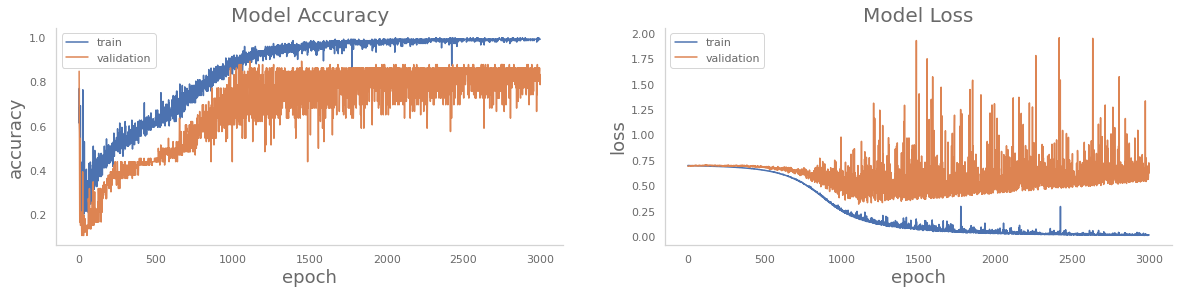

In [38]:
plot_acc_loss(ffnn_feature_history)

In [39]:
ffnn_feature_score = ffnn_feature.evaluate(x_test, y_test, verbose=2)

2/2 - 0s - loss: 1.4516 - accuracy: 0.6545


# KNN with feature extraction

In [40]:
x_train_feature_knn = [x.flatten() for x in x_train]
x_test_feature_knn = [x.flatten() for x in x_test]

In [45]:
knn_feature = KNeighborsClassifier(n_neighbors = 1, p = 2)
knn_feature.fit(x_train_feature_knn, y_train)
knn_feature_prediction_labels = knn_feature.predict(x_test_feature_knn)
print("KNN accuracy:", accuracy_score(y_test, knn_feature_prediction_labels))

KNN accuracy: 0.6363636363636364
